In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import parmap
from itertools import product
import sys
sys.path.append('../scripts/')
sys.path.append('../examples/')

from lindblad_solver import lindblad_solver
from utils import sx, sy, sz, si, init_qubit, normal_autocorr_generator
from dynamical_decoupling import dynamical_decoupling
from matplotlib import pyplot as plt
from scipy import optimize

In [3]:
def H_noise(t, delta_w_iterator):
    return -next(delta_w_iterator)*sz

def H_aux(t):
    return np.zeros((2,2),dtype=complex)
def add_noise(H,noise_matrix,mu,sigma,corr_time, dt,  seed):
    dw_it = normal_autocorr_generator(mu, sigma, corr_time / dt / 2, seed)
    def H_new(t,*args):
        return H(t,*args) + noise_matrix*next(dw_it)
    return H_new


In [24]:
def dd_parallel_noisy(H,tau_list, dt, N, mu, sigma, corr_time, repetitions):
    seed_list = np.arange(repetitions)

    values = list(product([H], [tau_list], dt, N, mu, sigma, corr_time, seed_list))
    results = parmap.starmap(dd_wrapper, values, pm_chunksize=4,pm_processes =4, pm_pbar=True)
    results = np.array(results)

    # Adapt results to input
    len_parameters = len(N) * len(dt) * len(mu) * len(sigma) * len(corr_time) 
    print(len_parameters)
    results = results.reshape((len_parameters, repetitions, tau_list.shape[0]))

    results_mean = results.mean(axis=-2)
    results_std = results.std(axis=-2) / np.sqrt(repetitions - 1)

    return results_mean,results_std



def dd_wrapper(H, tau_list, dt, N, mu, sigma, corr_time, seed):
    e = []

    # Initial state
    rho_0 = init_qubit([1, 0, 0])

    for tau_final in tau_list:
        _dt = min(dt,tau_final/5)
        tau = np.arange(tau_final, step=_dt)
        dw_it = normal_autocorr_generator(mu, sigma, corr_time / tau_final*tau.shape[0] / 2, seed)
        # H = add_noise(H,sz,mu, sigma, corr_time, _dt,  seed)

        rho = dynamical_decoupling(H, rho_0, N, tau_final, tau.shape[0], dw_it)
        e.append(np.trace(rho@sx)/2+1/2)
    return e



def dd_noise(H, tau_list, dt, N, mu, sigma, corr_time, seed):
    e = []
    
    #We add noise in Z componen
    noise_matrix = sz
    # Initial state
    rho_0 = init_qubit([1, 0, 0])

    for tau_final in tau_list:
        H = add_noise(H,mu,sigma,corr_time,dt, noise_matrix,seed)
        tau = np.arange(tau_final, step=dt)
        e.append(dynamical_decoupling(H, rho_0, N, tau_final, tau.shape[0]))
    return e

In [32]:
dt = [0.2] #3 Seems the right value.Higher gets crazy and lower does not really improve anything
N = [1]
sigma = [0.8,0.6]
mu = [0]
corr_time = [1000]
print(np.cbrt(12*corr_time[0]/sigma[0]**2))
repetitions = 100
n_tau = 25
tau_list = np.logspace(0,1.2,n_tau)
print(tau_list)
mean,std = dd_parallel_noisy(H_noise,tau_list, dt, N, mu, sigma, corr_time, repetitions)

26.566464229565273
[ 1.          1.12201845  1.25892541  1.41253754  1.58489319  1.77827941
  1.99526231  2.23872114  2.51188643  2.81838293  3.16227766  3.54813389
  3.98107171  4.46683592  5.01187234  5.62341325  6.30957344  7.07945784
  7.94328235  8.91250938 10.         11.22018454 12.58925412 14.12537545
 15.84893192]


100%|██████████| 200/200 [00:06<00:00, 33.22it/s]

2


What we see in this simulation is that the increase of sigma goes as expected. It decreases the value of $T_2$ as long as $\sigma\tau_c >>1$.

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[0.40402271] [[0.00055093]]
[0.4066459] [[0.00038343]]


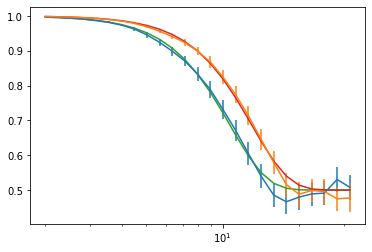

In [34]:
%notebook inline
plt.figure()
t = 2*tau_list
plt.errorbar(t,(mean[0, :]), (std[0, :]))
plt.errorbar(t, mean[1, :], std[1, :])
#plt.errorbar(t, mean[2, :], std[1, :])

def f(t,T2):
    return 1/2 + np.exp(-(t/T2)**3)/2

T_2 =[]
for i in range(2):
    s = sigma[i]
    c_time = corr_time[0]
    T2 = np.cbrt(12*c_time/s**2)
    
    guess = optimize.curve_fit(f, t, mean[i,:])[0]
    guess_std = optimize.curve_fit(f, t, mean[i,:])[1]

    
    y = 1/2 + 1/2 * np.exp(-(t/guess)**3)
    plt.plot(t,y)

    print(guess/T2 , guess_std/T2)




plt.xscale('log')
#plt.ylim(0.45,1)

plt.show()

[[1.6736637380011534]
 [1.5733851499841125]]
[[1.5936075394035862]
 [1.550976712452603]]


In [40]:
dt = [3]
N = [1,8,16]
sigma = [0.05]
mu = [0]
corr_time = [100000]

repetitions = 10
n_tau = 2
# Final t
t_list = np.logspace(1,4.5,n_tau)
print(t_list)
results = []
for n_rot in N:
    tau_list = t_list/2/n_rot
    new_result = dd_parallel_noisy(H_noise,tau_list, dt, [n_rot], mu, sigma, corr_time, repetitions)
    results.append(new_result)
    path = '../script_output/nv_deco_'+str(n_rot)
    print(path)
    np.savez(path)

[1.00000000e+01 3.16227766e+04]


12it [00:03,  3.43it/s]                       

1
../script_output/nv_deco_1



12it [00:00, 4096.33it/s]             


ValueError: Number of samples, -1, must be non-negative.

In [70]:
%matplotlib widget
t = t_list
for mean,std in results:  
    print(mean.shape)
    plt.errorbar(t, mean[0,:], std[0,:])

N = 4
c_time = corr_time[0]/16
T2 = np.cbrt(12*N**2*c_time/sigma[0]**2)
y = 1/2 + 1/2 * np.exp(-(t/T2)**3)

plt.plot(N*t,y)

plt.xscale('log')
plt.ylim(0.45,1)

plt.show()

(1, 50)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1, 50)
(1, 50)


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TypeError: 'float' object is not subscriptable

Realistic case

In [21]:
dt = [0.01]
N = [1,2,3,4]
sigma = [3.3]
mu = [0]
corr_time = [25]

repetitions = 1000
n_tau = 25

# Final t
t_list = np.linspace(0.1,4,n_tau)
results = []
for n_rot in N:
    tau_list = t_list/2/n_rot
    results.append(dd_parallel_noisy(H_noise,tau_list, dt, [n_rot], mu, sigma, corr_time, repetitions))

[0.1    0.2625 0.425  0.5875 0.75   0.9125 1.075  1.2375 1.4    1.5625
 1.725  1.8875 2.05   2.2125 2.375  2.5375 2.7    2.8625 3.025  3.1875
 3.35   3.5125 3.675  3.8375 4.    ]


1002it [00:54, 18.47it/s]                         

1



1002it [00:51, 19.45it/s]                         

1



1002it [00:55, 18.21it/s]                         

1



1002it [00:51, 19.53it/s]                         

1


In [22]:
%matplotlib widget
t = tau_list
for mean,std in results:  
    print(mean.shape)
    plt.errorbar(t, mean[0,:], std[0,:])


s = sigma[0]*11
N = 1
T2 = np.cbrt(12*corr_time[0]/s**2)
y = 1/2 + 1/2 * np.exp(-(t/T2)**3)

plt.plot(t,y)

plt.xscale('log')
plt.ylim(0.45,1)

plt.show()

(1, 25)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1, 25)
(1, 25)
(1, 25)


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
